# Import

In [2]:
import numpy as np
import os
from scipy.special import expit
import matplotlib.pyplot as plt

# Define

In [24]:
def IsNone(target):
    return (type(target) == type(None))

def ArraySign(input_array):
    # return +1, 0, -1 respect to positive, zero, negtive
    return 1.*(input_array>0) - 1.*(input_array<0)

def CutValue(input_array, cut_value):
    output = np.abs(input_array)
    output = ArraySign(input_array) * (output * (output < cut_value) + cut_value * (output >= cut_value))
    return output

def WeightedSum(input_array, weight):
    try:
        return (input_array.reshape(-1)*weight).sum()
    except:
        raise ValueError("weight should be an 1-d array with the same size with input_array")

def WeightedRow(input_array, weight):
    try:
        return input_array*weight.reshape(-1,1)
    except:
        raise ValueError("weight should be an 1-d array with the same length with first shape of input_array")

def OverPenalty(input_value, rate = 0.1, threshold=0.):
    output = np.abs(input_value) - threshold
    output *= (output > 0)
    output *= rate * ArraySign(input_value)
    return output

def RowOperate(matrix, threshold = 0.000000000000001, large_element_alert=False):
    # matrix : matrix with rows > columns
    reduced_matrix = np.array(matrix)
    filtered_matrix = np.array(matrix)
    shape = matrix.shape # matrix size
    mask = np.ones(shape)
    pivots = -1*np.ones((min(shape)), dtype = np.int) # store pivots, (# of pivots) <= min(rows, columns)
    for p in range(len(pivots)):
        filtered_matrix = reduced_matrix * mask # filter
        if np.abs(filtered_matrix).max() < threshold:
            print("WARNING : input rows not independ for threshold %d when apply row operation" %(threshold))
            break
        
        pivot_row, pivot_col = np.unravel_index(np.abs(filtered_matrix).argmax(), shape) # pivot row, pivot column
        reduced_matrix[pivot_row] /= reduced_matrix[pivot_row][pivot_col]
        multi = np.array(reduced_matrix[:, pivot_col])
        multi[pivot_row] = 0.
        reduced_matrix -= np.dot(multi.reshape((-1, 1)), reduced_matrix[pivot_row].reshape((1, -1)))
        mask[pivot_row] = 0.
        mask[:, pivot_col] = 0.
        pivots[pivot_row] = pivot_col # the column-index of pivot_row-th row is pivot_col
    
    reduced_matrix = reduced_matrix[pivots != -1,:]
    pivots = pivots[pivots != -1]
    if large_element_alert:
        if np.abs(reduced_matrix).max() > 1.01:
            print("WARNING : reduced matrix has large element %f" %(np.abs(reduced_matrix).max()))
        
    
    return reduced_matrix, pivots

def LinearRefine(regressor, response, num_elimination=1, regularizer=0.):
    if (regressor.ndim != 2) or (regressor.size == 0):
        raise ValueError("regressor should be a non-empty numpy matrix")
    elif (response.ndim != 2) or (response.size == 0):
        raise ValueError("response should be a non-empty numpy matrix")
    elif len(regressor) != len(response):
        raise ValueError("len(regressor) != len(response)")
    
    if regularizer < 0.:
        regularizer = 0.
        print("SetRegularizer error, regularizer must be non-negative, has been set to zero.")
    
    num_var = regressor.shape[1]
    regressor = np.append(regressor, np.ones((len(regressor), 1)), axis=1) # add bias
    gram = np.dot(regressor.T, regressor)
    gram += regularizer * regressor.shape[0] * np.identity(regressor.shape[1])
    projected = np.dot(regressor.T, response)
    is_leave = np.ones((gram.shape[0]), dtype=bool)
    response_square = np.square(response).sum(axis=0)
    for d in range(num_elimination):
        square_err = np.inf * np.ones((gram.shape[0]), dtype=bool)
        for i in range(num_var):
            if is_leave[i]:
                work_index = (is_leave * (np.arange(len(is_leave)) != i)).astype(bool)
                coe = np.linalg.solve(gram[work_index][:, work_index], projected[work_index])
                square_err[i] = (response_square
                                 - (coe * projected[work_index]).sum(axis=0) 
                                 - regularizer * np.square(coe).sum(axis=0)
                                ).sum()
        
        is_leave[np.argmin(square_err)] = False
    
    rms = square_err.min()/(regressor.shape[0] - is_leave.sum())
    coe = np.linalg.solve(gram[is_leave][:, is_leave], projected[is_leave])
    bias = coe[-1].reshape(1, -1)
    return is_leave[:-1], coe[:-1], bias, rms

def McmcNormal(points, drop_times = 10, mean=0., std=1.):
    # Useing Markov chain Monte Carlo method to get a new point from normal distribution with given points
    # each element is get from mean and std
    output = np.random.normal(mean, std, points.shape[1:])
    if drop_times > 1:
        for t in range(1, drop_times):
            candicate = np.random.normal(mean, std, points.shape[1:])
            candicate_distance = np.sqrt(np.square(np.subtract(points, candicate)).sum(axis=tuple(np.arange(1, len(points.shape))))).min()
            # distance of candicate to target
            output_distance = np.sqrt(np.square(np.subtract(points, output)).sum(axis=tuple(np.arange(1, len(points.shape))))).min()
            # distance of currently output to target
            if np.random.rand()*output_distance < candicate_distance:
                output = np.array(candicate)
    
    return output

def McmcColExtend(input_matrix, drop_times, extend_min=0.):
    # return a matrix with a new col with same level by McmcNormal
    input_matrix = input_matrix.T # transpose cols to rows
    output = np.insert(input_matrix,
                       len(input_matrix),
                       McmcNormal(input_matrix, drop_times, 0, max(extend_min, np.sqrt(np.square(input_matrix).mean()))),
                       axis=0
                      ).T # transpose rows back to cols
    return output

# Data

class Data():
    def __init__(self, inputs=np.zeros((0,0)), labels=np.zeros((0,0)), weight = None):
        self.SetData(inputs, labels, weight)
    
    def SetData(self, inputs=np.zeros((0,0)), labels=np.zeros((0,0)), weight = None):
        if len(inputs) != len(labels):
            raise ValueError("num_datums error, #inputs != #labels.")
        
        self.inputs = inputs
        self.labels = labels
        if IsNone(weight):
            self.weight = np.ones((inputs.shape[0]))
        elif weight.shape != (len(inputs)):
            self.weight = np.ones((inputs.shape[0]))
            print("WARNING : weight shape error, set uniform weight.")
        elif weight.sum() <= 0:
            self.weight = np.ones((inputs.shape[0]))
            print("WARNING : get non-positive weight sum, set uniform weight.")
        else:
            self.weight = weight
        
        self.weight /= self.weight.sum()
    
    def GetNumDatums(self):
        return len(self.inputs)
    
    def GetDatumSize(self):
        # return size of input and label
        return (self.inputs.shape[1], self.labels.shape[1])
    
    def Shuffle(self):
        # shuffling datumds
        new_index = np.arange(self.GetNumDatums())
        np.random.shuffle(new_index)
        self.inputs = self.inputs[new_index]
        self.labels = self.labels[new_index]
    
    def IsClassification(self):
        # cheaking if labels of this data is classification
        # By cheaking:
        # 1. labels have only two value : 0, 1
        # 2. two or more classes
        # 3. each datum has unique 1
        output = ((self.labels == 0) + (self.labels == 1)).all()
        output *= (self.labels.shape[1]>1)
        output *= (self.labels.sum(axis=1)==1).all()
        return output

# Data end

# VariableArray

class VariableArray():
    def __init__(self, size, cwise_step_initial=0.1):
        self.value = np.random.normal(0., 1., size) # array value
        self.total_deri = np.zeros(self.value.shape) # total derivative, used to descent
        self.last_total_deri = np.zeros(self.value.shape) # last total derivative
        self.moving = np.zeros(self.value.shape) # moving array
        self.cwise_step = cwise_step_initial*np.ones(self.value.shape) # component-wise step
        
        self.regulariz_rate = 0.
        self.regulariz_margin = 0.
    
    def SetValue(self, input_value, cwise_step_initial=0.1):
        self.value = np.array(input_value) # array value
        self.total_deri = np.zeros(self.value.shape) # total derivative, used to descent
        self.last_total_deri = np.zeros(self.value.shape) # last total derivative
        self.moving = np.zeros(self.value.shape) # moving array
        self.cwise_step = cwise_step_initial*np.ones(self.value.shape) # component-wise step
    
    def SetDeri(self, input_value):
        if input_value.shape != self.total_deri.shape:
            raise ValueError("input_value shape error")
        
        self.total_deri = np.array(input_value)
    
    def DeriModify(self, input_value):
        if input_value.shape != self.total_deri.shape:
            raise ValueError("input_value shape error")
        
        self.total_deri += input_value
    
    def ZeroDeri(self):
        self.total_deri *= 0
    
    def SetRegularizer(self, rate, margin):
        self.regulariz_rate = max(rate, 0.)
        self.regulariz_margin = max(margin, 0.)
    
    def ResetCwiseStep(self, new_cwise_step):
        self.cwise_step = new_cwise_step * np.ones(self.cwise_step.shape)
    
    def Regularize(self):
        if self.regulariz_rate != 0:
            self.total_deri += OverPenalty(self.value, self.regulariz_rate, self.regulariz_margin)
    
    def Descent(self, step=1., method="normal", move_max=1.):
        self.Regularize()
        if method == "normal":
            self.moving = self.total_deri * step
            self.moving = -1*CutValue(self.moving, move_max)
        elif method == "Rprop":
            self.moving = ArraySign(self.total_deri)
            self.movint_return = ArraySign(self.total_deri*self.last_total_deri)
            self.cwise_step *= 1.2*(self.movint_return>0) + 1.*(self.movint_return==0) + 0.5*(self.movint_return<0)
            self.cwise_step = CutValue(self.cwise_step, move_max)
            self.moving *= -1*self.cwise_step
        else:
            raise ValueError("descent method error")
        
        self.value += self.moving
        
        self.last_total_deri = np.array(self.total_deri)
        self.ZeroDeri()

# VariableArray end

# Activation functions defined start

class Identity():
    def Forward(self, flow_in):
        return flow_in
    
    def Diff(self, flow_in):
        return np.ones(flow_in.shape, dtype = np.float64)
    
    def Backward(self, flow_in, back_flow):
        return self.Diff(flow_in) * back_flow

class Sigmoid():
    def Forward(self, flow_in):
        return expit(flow_in)
    
    def Diff(self, flow_in):
        return expit(flow_in)*expit(-flow_in)
    
    def Backward(self, flow_in, back_flow):
        return self.Diff(flow_in) * back_flow

class Hypertan():
    def Forward(self, flow_in):
        flow_in = CutValue(flow_in, 100)
        return np.tanh(flow_in)
    
    def Diff(self, flow_in):
        flow_in = CutValue(flow_in, 100) # cut value out of [-100, 100] to 100, cosh(-100) = cosh(100)
        return 1. / np.square(np.cosh(flow_in))
    
    def Backward(self, flow_in, back_flow):
        return self.Diff(flow_in) * back_flow

class SoftSign():
    def Forward(self, flow_in):
        return ArraySign(flow_in)*(1. - 1./(np.abs(flow_in) + 1.))
    
    def Diff(self, flow_in):
        return 1. / np.square(np.abs(flow_in) + 1.)
    
    def Backward(self, flow_in, back_flow):
        return self.Diff(flow_in) * back_flow

class Relu():
    def Forward(self, flow_in):
        return flow_in*(flow_in>0)
    
    def Diff(self, flow_in):
        return 1.*(flow_in>0)
    
    def Backward(self, flow_in, back_flow):
        return self.Diff(flow_in) * back_flow

class LeakyRelu():
    def __init__(self, alpha = 0.1):
        self.alpha = alpha
    
    def Forward(self, flow_in):
        return flow_in*(flow_in>0) + self.alpha*flow_in*(flow_in<0)
    
    def Diff(self, flow_in):
        return 1.*(flow_in>0) + self.alpha*(flow_in<0)
    
    def Backward(self, flow_in, back_flow):
        return self.Diff(flow_in) * back_flow

class SoftPlus():
    def Forward(self, flow_in):
        return np.log(1. + np.exp(flow_in))
    
    def Diff(self, flow_in):
        return expit(flow_in)
    
    def Backward(self, flow_in, back_flow):
        return self.Diff(flow_in) * back_flow

class Selu():
    def __init__(self):
        self.ahpha = 1.05071
        self.beta = 1.67326
    
    def Forward(self, flow_in):
        return self.ahpha*(flow_in*(flow_in>=0) + self.beta*(np.exp(flow_in) - 1)*(flow_in<0))
    
    def Diff(self, flow_in):
        return self.ahpha*(1.*(flow_in>=0) + self.beta*np.exp(flow_in)*(flow_in<0))
    
    def Backward(self, flow_in, back_flow):
        return self.Diff(flow_in) * back_flow

class Softmax():
    def Forward(self, flow_in):
        output = flow_in - flow_in.max(axis=1).reshape(-1,1)
        output = np.exp(output)
        output /= output.sum(axis=1).reshape(-1,1)
        return output
    
    def Backward(self, flow_in, back_flow):
        flow_out = self.Forward(flow_in) # result of self.trans
        return flow_out*back_flow - flow_out*((flow_out*back_flow).sum(axis=1).reshape(-1,1))

# Activation functions defined end

# Layer

class Layer():
    def __init__(self, num_unit, activationFunction):
        if type(activationFunction) == type:
            raise TypeError("activationFunction should be a class. eg: Use 'Sigmoid()', not 'Sigmoid'")
        
        self.num_unit = num_unit
        self.activationFunction = activationFunction
        self.linear = VariableArray((0, self.num_unit)) # linear weights working before active function
        self.bias = VariableArray((1, self.num_unit)) # bias working before active function
        self.flow_in = np.zeros((0, self.num_unit))
        self.flow_out = np.zeros((0, self.num_unit))
    
    def Forward(self, flow_in):
        self.flow_in = np.dot(flow_in, self.linear.value) + self.bias.value
        self.flow_out = self.activationFunction.Forward(self.flow_in)
    
    def Backward(self, back_flow, layer_source):
        deri = self.activationFunction.Backward(self.flow_in, back_flow)
        self.linear.DeriModify(np.dot(layer_source.T, deri))
        self.bias.DeriModify(np.sum(deri, axis=0).reshape(1, -1))
        deri = np.dot(deri, self.linear.value.T)
        return deri
    
    def ZeroDeri(self):
        self.linear.ZeroDeri()
        self.bias.ZeroDeri()
    
    def SetRegularizer(self, rate, margin):
        self.linear.SetRegularizer(rate, margin)
        self.bias.SetRegularizer(rate, margin)
    
    def Descent(self, step, method):
        self.linear.Descent(step, method)
        self.bias.Descent(step, method)
    
    def ResetCwiseStep(self, new_cwise_step):
        self.linear.ResetCwiseStep(new_cwise_step)
        self.bias.ResetCwiseStep(new_cwise_step)
        
    def GetPCVar(self, weight):
        if IsNone(weight):
            weight = np.ones((self.flow_out.shape[0])) / self.flow_out.shape[0]
        
        mean_flow_out = self.flow_out.mean(axis=0)
        centered_flow_out = self.flow_out - mean_flow_out
        cov = np.dot(centered_flow_out.T * weight, centered_flow_out) # covariance matrix
        information= np.linalg.eigvalsh(cov) #information is sorted from small to large
        return information
    
    def GetDimension(self):
        return self.linear.value.size + self.bias.value.size

# Layer end

# Loss function

class LossFunction():
    def __init__(self, method):
        self.method = method
    
    def SetMethod(self, method):
        self.method = method
    
    def GetLoss(self, inference, target, weight):
        if self.method == "r2":
            output = WeightedSum(np.square(inference - target).sum(axis=1), weight)
            output /= WeightedSum(np.square(target - target.mean(axis=0)).sum(axis=1), weight)
        elif self.method == "cross entropy":
            output = WeightedSum((-target*np.log(inference)).sum(axis=1), weight)
        else:
            raise ValueError("loss function method should be 'r2', 'cross entropy'")
        
        return output
    
    def Backward(self, inference, target, weight):
        if self.method == "r2":
            output = WeightedRow(2.*(inference - target), weight)
            output /= WeightedSum(np.square(target - target.mean(axis=0)).sum(axis=1), weight)
        elif self.method == "cross entropy":
            output = WeightedRow(-(target/inference), weight)
        else:
            raise ValueError("loss function method should be 'r2', 'cross entropy'")
        
        return output

class Terminator():
    def __init__(self, short_period = 5, long_period = 10, threshold = 0.):
        try:
            short_period = int(short_period)
            long_period = int(long_period)
        except:
            raise ValueError("period should be a value, and will be transfer to int")
        
        if short_period <= 0:
            short_period = 1
            print("WARNING : short_period <= 0, set 1")
        
        if long_period <= short_period:
            long_period = short_period + 1
            print("WARNING : long_period <= short_period, set short_period + 1")
        
        self.short_period = short_period
        self.long_period = long_period
        self.threshold = threshold
        self.record = []
    
    def Reset(self, short_period, long_period, threshold = 0.):
        try:
            short_period = int(short_period)
            long_period = int(long_period)
        except:
            raise ValueError("period should be a value, and will be transfer to int")
        
        if short_period <= 0:
            short_period = 1
            print("WARNING : short_period <= 0, set 1")
        
        if long_period <= short_period:
            long_period = short_period + 1
            print("WARNING : long_period <= short_period, set %d" %(short_period + 1))
        
        self.short_period = short_period
        self.long_period = long_period
        self.threshold = threshold
        self.record = []
    
    def Hit(self, input_value):
        try:
            input_value = float(input_value)
        except:
            raise ValueError("input_value should be a real value")
        
        self.record = [input_value] + self.record[:self.long_period-1]
        if len(self.record) == self.long_period:
            return (np.mean(self.record[:self.short_period]) - self.threshold > np.mean(self.record))
        else:
            return False
    
    def Clear(self):
        self.record = []

class DogikoNeuralNetwork():
    def __init__(self):
        self.hiddenLayerList = []
        self.outputFunction = None
        self.outputLayer = None
        self.lossFunction = None
        self.trainData = Data()
        self.validData = Data()
        self.testData = Data()
        self.regulariz_rate = 0.
        self.regulariz_margin = 0.
        self.has_build = False
        self.hit_tolerance = 0.1
        self.terminator = Terminator()
    
    def SetLossFunction(self, method):
        if method not in ["r2", "cross entropy"]:
            raise ValueError("loss function method should be 'r2', 'cross entropy'")
        
        self.lossFunction = LossFunction(method)
    
    def SetRegularizer(self, rate, margin):
        if rate < 0.:
            print("WARNING : regulariz_rate error, get negative value, setting to 0.")
        
        if margin < 0.:
            print("WARNING : regulariz_margin error, get negative value, setting to 0.")
        
        self.regulariz_rate = max(rate, 0.)
        self.regulariz_margin = max(margin, 0.)
        
        if self.has_build:
            for l in range(self.GetNumHiddenLayers()):
                self.hiddenLayerList[l].SetRegularizer(self.regulariz_rate, self.regulariz_margin)
            
            self.outputLayer.SetRegularizer(self.regulariz_rate, self.regulariz_margin)
    
    def SetTrainData(self, inputs, labels, weight = None):
        if self.has_build:
            if inputs.shape[1] != self.inputs_size:
                raise ValueError("inputs size doesn't match with this model")
            
            if labels.shape[1] != self.labels_size:
                raise ValueError("labels size doesn't match with this model")
        
        self.trainData.SetData(inputs, labels, weight)
    
    def SetValidData(self, inputs, labels, weight = None):
        if self.has_build:
            if inputs.shape[1] != self.inputs_size:
                raise ValueError("inputs size doesn't match with this model")
            
            if labels.shape[1] != self.labels_size:
                raise ValueError("labels size doesn't match with this model")
        
        self.validData.SetData(inputs, labels, weight)
    
    def SetTestData(self, inputs, labels, weight = None):
        if self.has_build:
            if inputs.shape[1] != self.inputs_size:
                raise ValueError("inputs size doesn't match with this model")
            
            if labels.shape[1] != self.labels_size:
                raise ValueError("labels size doesn't match with this model")
        
        self.testData.SetData(inputs, labels, weight)
    
    def AddHiddenLayer(self, num_unit, activationFunction):
        self.hiddenLayerList.append(Layer(num_unit, activationFunction))
        if self.has_build:
            print("WARNING : a hidden layer added after build, please re-build model or set related value manually.")
    
    def SetOutputFunction(self, activationFunction):
        # units of output layer is fixed as same as label size
        self.outputFunction = activationFunction
        if self.has_build:
            self.outputLayer.activationFunction = self.outputFunction
    
    def SetHitTolerance(self, tolerance):
        try:
            if float(tolerance) <= 0.:
                print("setting tolerance failed, tolerance should be positive real value")
            
            self.hit_tolerance = float(tolerance)
        except:
            print("setting tolerance failed, tolerance should be positive real value")
    
    def SetTerminator(self, short_period, long_period, threshold = 0.):
        self.terminator.Reset(short_period, long_period, threshold)
        
    def ClearTerminator(self):
        self.terminator.Clear()
    
    def GetNumHiddenLayers(self):
        return len(self.hiddenLayerList)
    
    def Build(self):
        if IsNone(self.lossFunction):
            raise ValueError("Set loss function before build.")
        
        if self.lossFunction.method == "cross entropy":
            if type(self.outputFunction) not in [Sigmoid, Softmax, SoftSign]:
                print ("WARNING : chosen loss function is cross entropy but the output of output layer function may out of (0, 1)")
            
        
        if IsNone(self.outputFunction):
            self.outputFunction = Identity()
            print ("WARNING : doesn't set outputFunction before build, set Identity().")
        
        if len(set([self.trainData.GetDatumSize()[0],
                    self.validData.GetDatumSize()[0],
                    self.testData.GetDatumSize()[0]
                   ])) == 1:
            self.inputs_size = self.trainData.GetDatumSize()[0]
        else:
            raise ValueError("train, valid, test data must have the same inputs size")
        
        if len(set([self.trainData.GetDatumSize()[1],
                    self.validData.GetDatumSize()[1],
                    self.testData.GetDatumSize()[1]
                   ])) == 1:
            self.labels_size = self.trainData.GetDatumSize()[1]
        else:
            raise ValueError("train, valid, test data must have the same labels size")
        
        # when hidden layer exist, set first layer value
        if self.GetNumHiddenLayers() >0:
            self.hiddenLayerList[0].linear.SetValue(np.random.normal(0.,
                                                                     1.,
                                                                     (self.inputs_size, self.hiddenLayerList[0].num_unit)
                                                                    )
                                                   )
            self.hiddenLayerList[0].bias.SetValue(np.random.normal(0.,
                                                                   1.,
                                                                   (1, self.hiddenLayerList[0].num_unit)
                                                                  )
                                                 )
            # normalize flow_in by modify layer variables
            self.hiddenLayerList[0].Forward(self.trainData.inputs)
            flow_in_mean = self.hiddenLayerList[0].flow_in.mean(axis=0)
            flow_in_std = self.hiddenLayerList[0].flow_in.std(axis=0) + 0.000000001 # bias for prevent zero std
            self.hiddenLayerList[0].linear.value /= flow_in_std
            self.hiddenLayerList[0].bias.value -= flow_in_mean
            self.hiddenLayerList[0].bias.value /= flow_in_std
            self.hiddenLayerList[0].Forward(self.trainData.inputs)
            # when hidden layer num >= 2, set internal layer value
            for l in range(1, self.GetNumHiddenLayers()):
                self.hiddenLayerList[l].linear.SetValue(np.random.normal(0.,
                                                                         1.,
                                                                         (self.hiddenLayerList[l-1].num_unit,
                                                                          self.hiddenLayerList[l].num_unit
                                                                         )
                                                                        )
                                                       )
                self.hiddenLayerList[l].bias.SetValue(np.random.normal(0.,
                                                                       1.,
                                                                       (1, self.hiddenLayerList[l].num_unit)
                                                                      )
                                                     )
                # normalize flow_in by modify layer variables
                self.hiddenLayerList[l].Forward(self.hiddenLayerList[l-1].flow_out)
                flow_in_mean = self.hiddenLayerList[l].flow_in.mean(axis=0)
                flow_in_std = self.hiddenLayerList[l].flow_in.std(axis=0) + 0.000000001 # bias for prevent zero std
                self.hiddenLayerList[l].linear.value /= flow_in_std
                self.hiddenLayerList[l].bias.value -= flow_in_mean
                self.hiddenLayerList[l].bias.value /= flow_in_std
                self.hiddenLayerList[l].Forward(self.hiddenLayerList[l-1].flow_out)
            
            # set output layer
            self.outputLayer = Layer(self.labels_size, self.outputFunction)
            self.outputLayer.linear.SetValue(np.random.normal(0.,
                                                              1.,
                                                              (self.hiddenLayerList[-1].num_unit,
                                                               self.outputLayer.num_unit
                                                              )
                                                             )
                                            )
            # normalize flow_in by modify layer variables
            self.outputLayer.Forward(self.hiddenLayerList[-1].flow_out)
            flow_in_mean = self.outputLayer.flow_in.mean(axis=0)
            flow_in_std = self.outputLayer.flow_in.std(axis=0) + 0.000000001 # bias for prevent zero std
            self.outputLayer.linear.value /= flow_in_std
            self.outputLayer.bias.value -= flow_in_mean
            self.outputLayer.bias.value /= flow_in_std
            self.outputLayer.Forward(self.hiddenLayerList[-1].flow_out)
            
        else: # case no hiddenlayer
            self.outputLayer.linear.SetValue(np.random.normal(0.,
                                                              1.,
                                                              (self.inputs_size,
                                                               self.outputLayer.num_unit
                                                              )
                                                             )
                                            )
        
            self.outputLayer.bias.SetValue(np.random.normal(0.,
                                                            1.,
                                                            (1, self.outputLayer.num_unit)
                                                           )
                                          )
            # normalize flow out to fit labels by modify layer variables
            self.outputLayer.Forward(self.trainData.inputs)
            flow_in_mean = self.outputLayer.flow_in.mean(axis=0)
            flow_in_std = self.outputLayer.flow_in.std(axis=0) + 0.000000001 # bias for prevent zero std
            self.outputLayer.linear.value /= flow_in_std
            self.outputLayer.bias.value -= flow_in_mean
            self.outputLayer.bias.value /= flow_in_std
            self.outputLayer.Forward(self.trainData.inputs)
        
        # Set regularizer
        for l in range(self.GetNumHiddenLayers()):
            self.hiddenLayerList[l].SetRegularizer(self.regulariz_rate, self.regulariz_margin)
        
        self.outputLayer.SetRegularizer(self.regulariz_rate, self.regulariz_margin)
        
        self.has_build = True
    
    def save_model(self, target_folder):
        if type(target_folder) != str:
            raise TypeError("target_folder should be a str")
        
        while target_folder[-1] =="/":
            target_folder = target_folder[:-1]
        
        if not os.path.exists(target_folder):
            os.makedirs(target_folder)
        
        target_folder += "/"
        
        info_dict = {}
        info_dict["inputs size"] = self.inputs_size
        info_dict["labels size"] = self.labels_size
        info_dict["loss"] = self.lossFunction.method
        info_dict["regularizer"] = {"rate" : self.regulariz_rate,
                                    "margin" : self.regulariz_margin
                                   }
        info_dict["tolerance"] = self.hit_tolerance
        info_dict["num units"] = []
        info_dict["activation function"] = []
        for l in range(self.GetNumHiddenLayers()):
            info_dict["num units"].append(self.hiddenLayerList[l].num_unit)
            info_dict["activation function"].append(self.hiddenLayerList[l].activationFunction)
        
        info_dict["output function"] = self.outputFunction
        info_dict["terminator"] = self.terminator
        np.save(target_folder + "model_info.npy", info_dict)
        for l in range(self.GetNumHiddenLayers()):
            np.save(target_folder + "L%d.npy" %(l), self.hiddenLayerList[l].linear.value)
            np.save(target_folder + "B%d.npy" %(l), self.hiddenLayerList[l].bias.value)
        
        np.save(target_folder + "Lo.npy" , self.outputLayer.linear.value)
        np.save(target_folder + "Bo.npy" , self.outputLayer.bias.value)
    
    def load_model(self, target_folder):
        if len(set([self.trainData.GetDatumSize()[0],
                    self.validData.GetDatumSize()[0],
                    self.testData.GetDatumSize()[0]
                   ])) == 1:
            self.inputs_size = self.trainData.GetDatumSize()[0]
        else:
            raise ValueError("train, valid, test data must have the same inputs size")
        
        if len(set([self.trainData.GetDatumSize()[1],
                    self.validData.GetDatumSize()[1],
                    self.testData.GetDatumSize()[1]
                   ])) == 1:
            self.labels_size = self.trainData.GetDatumSize()[1]
        else:
            raise ValueError("train, valid, test data must have the same labels size")
        
        if type(target_folder) != str:
            raise TypeError("target_folder should be a str")
        
        while target_folder[-1] =="/":
            target_folder = target_folder[:-1]
        
        target_folder += "/"
        
        self.has_build = False
        
        info_dict = np.load(target_folder + "model_info.npy").item()
        if self.trainData.GetDatumSize() != (info_dict["inputs size"], info_dict["labels size"]):
            raise ValueError("Datum size error, (inputs size, output size) for this model should be (%d, %d)" %self.trainData.GetDatumSize())
        
        self.SetLossFunction(info_dict["loss"])
        self.SetRegularizer(info_dict["regularizer"]["rate"], info_dict["regularizer"]["margin"])
        self.hit_tolerance = info_dict["tolerance"]
        
        self.hiddenLayerList = []
        for l in range(len(info_dict["num units"])):
            self.AddHiddenLayer(info_dict["num units"][l], info_dict["activation function"][l])
        
        self.SetOutputFunction(info_dict["output function"])
        self.terminator = info_dict["terminator"]
        self.Build()
        
        for l in range(len(info_dict["num units"])):
            self.hiddenLayerList[l].linear.value = np.load(target_folder + "L%d.npy" %(l))
            self.hiddenLayerList[l].bias.value = np.load(target_folder + "B%d.npy" %(l))
        
        self.outputLayer.linear.value = np.load(target_folder + "Lo.npy")
        self.outputLayer.bias.value = np.load(target_folder + "Bo.npy")
    
    def GetDimension(self):
        output = self.outputLayer.GetDimension()
        for l in range(self.GetNumHiddenLayers()):
            output += self.hiddenLayerList[l].GetDimension()
        
        return output
    
    def GetInference(self, inputs):
        if inputs.shape[1] != self.inputs_size:
            raise ValueError("inputs size shoud be %d, get %d" %(self.inputs_size, inputs.shape[1]))
        
        if self.GetNumHiddenLayers() > 0:
            self.hiddenLayerList[0].Forward(inputs)
            for l in range(1, self.GetNumHiddenLayers()):
                self.hiddenLayerList[l].Forward(self.hiddenLayerList[l-1].flow_out)
            
            self.outputLayer.Forward(self.hiddenLayerList[-1].flow_out)
        else:
            self.outputLayer.Forward(inputs)
        
        return self.outputLayer.flow_out
    
    def GetLoss(self, inference, target, weight = None):
        if inference.shape != target.shape:
            raise ValueError("shape between inference and target non-equal")
        
        return self.lossFunction.GetLoss(inference, target, weight)
    
    def GetTrainLoss(self):
        return self.GetLoss(self.GetInference(self.trainData.inputs), self.trainData.labels, self.trainData.weight)
    
    def GetValidLoss(self):
        return self.GetLoss(self.GetInference(self.validData.inputs), self.validData.labels, self.validData.weight)
    
    def GetTestLoss(self):
        return self.GetLoss(self.GetInference(self.testData.inputs), self.testData.labels, self.testData.weight)
    
    def GetAccuracy(self, inference, target, decimals=4, tolerance = 0.1):
        # tolerance : for regression(r2) model, given a tolerance to verify hit or miss,
        #             this variable is meaningless for classifycation
        if self.lossFunction.method == "cross entropy":
            output = (inference.argmax(axis=1) == target.argmax(axis=1)).mean()
        elif self.lossFunction.method == "r2":
            output = np.square(inference - target).sum(axis=1)
            output = (output < tolerance).mean()
        
        return np.round(output, decimals)
    
    def GetTrainAccuracy(self, tolerance = None, decimals=4):
        if IsNone(tolerance):
            tolerance = self.hit_tolerance
        
        return self.GetAccuracy(self.GetInference(self.trainData.inputs), self.trainData.labels, decimals, tolerance)
    
    def GetValidAccuracy(self, tolerance = None, decimals=4):
        if IsNone(tolerance):
            tolerance = self.hit_tolerance
        
        return self.GetAccuracy(self.GetInference(self.validData.inputs), self.validData.labels, decimals, tolerance)
    
    def GetTestAccuracy(self, tolerance = None, decimals=4):
        if IsNone(tolerance):
            tolerance = self.hit_tolerance
        
        return self.GetAccuracy(self.GetInference(self.testData.inputs), self.testData.labels, decimals, tolerance)
    
    def Backward(self, inputs, labels, weight):
        deri = self.lossFunction.Backward(self.GetInference(inputs), labels, weight)
        if self.GetNumHiddenLayers() > 0:
            deri = self.outputLayer.Backward(deri, self.hiddenLayerList[-1].flow_out)
            for l in range(self.GetNumHiddenLayers()-1, 0, -1):
                deri = self.hiddenLayerList[l].Backward(deri, self.hiddenLayerList[l-1].flow_out)
            
            deri = self.hiddenLayerList[0].Backward(deri, inputs)
        else:
            deri = self.outputLayer.Backward(deri, inputs)
        
    def ZeroDeri(self):
        for l in range(self.GetNumHiddenLayers()):
            deri = self.hiddenLayerList[l].ZeroDeri()
        
        deri = self.outputLayer.ZeroDeri()
    
    def ResetCwiseStep(self, new_cwise_step=0.1):
        for l in range(self.GetNumHiddenLayers()):
            deri = self.hiddenLayerList[l].ResetCwiseStep(new_cwise_step)
        
        deri = self.outputLayer.ResetCwiseStep(new_cwise_step)
    
    def Descent(self, step = 1., method = "normal"):
        for l in range(self.GetNumHiddenLayers()):
            self.hiddenLayerList[l].Descent(step, method)
        
        self.outputLayer.Descent(step, method)
    
    def BatchFit(self, batch_inputs, batch_labels, batch_weight, step = 1., method = "normal"):
        batch_weight /= batch_weight.sum()
        self.Backward(batch_inputs, batch_labels, batch_weight)
        self.Descent(step, method)
    
    def EpochFit(self, batch_size = None, step = 1., method = "normal"):
        if type(batch_size) == type(None):
            self.BatchFit(self.trainData.inputs, self.trainData.labels, self.trainData.weight, step, method)
        elif type(batch_size) == int:
            if batch_size > 0:
                for b in range(np.ceil(self.trainData.GetNumDatums()/ batch_size).astype(np.int)):
                    self.BatchFit(self.trainData.inputs[b*batch_size: (b+1)*batch_size],
                                  self.trainData.labels[b*batch_size: (b+1)*batch_size],
                                  self.trainData.weight[b*batch_size: (b+1)*batch_size],
                                  step,
                                  method
                                 )
            else:
                raise ValueError("batch_size should be positive int")
        
        else:
            raise ValueError("batch_size should be positive int")
    
    def Train(self, times, batch_size = None, step = 1., method = "normal", is_termination = False, shuffling = False):
        self.terminator.Clear()
        for t in range(times):
            if shuffling:
                self.trainData.Shuffle()
            
            self.EpochFit(batch_size, step, method)
            if is_termination:
                if self.terminator.Hit(10*np.log10(self.GetValidLoss() + 0.000000001)):
                # 0.000000001, bias for prevent error when log(0)
                    return t+1
        
        return times
    
    def AddUnit(self, layer_index, num_added = 1, output_linear_bound = 1., cwise_step_initial = 0.1, drop_times=5):
        if layer_index not in range(self.GetNumHiddenLayers()):
            raise ValueError("layer_index should be an int from 0 to (#layer-1) for hiddenlayer")
        
        if type(num_added) != int:
            raise ValueError("num_added should be positive int")
        elif num_added <= 0:
            raise ValueError("num_added should be positive int")
        
        try:
            if output_linear_bound < 0.:
                raise ValueError("output_weight_bound should be non-negative")
        except:
            raise ValueError("output_weight_bound should a non-negative real value")
        
        new_linear = self.hiddenLayerList[layer_index].linear.value
        new_bias = self.hiddenLayerList[layer_index].bias.value
        for u in range(num_added):
            new_linear = McmcColExtend(new_linear, drop_times)
            new_bias = McmcColExtend(new_bias, drop_times)
        
        self.hiddenLayerList[layer_index].linear.SetValue(new_linear, cwise_step_initial)
        self.hiddenLayerList[layer_index].bias.SetValue(new_bias, cwise_step_initial)
        
        if layer_index < self.GetNumHiddenLayers() - 1: # if not final hiddenlayer
            new_output_linear = self.hiddenLayerList[layer_index+1].linear.value
            new_output_linear = np.append(new_output_linear,
                                          output_linear_bound * (2 * np.random.rand(num_added, self.hiddenLayerList[layer_index+1].num_unit) - 1),
                                          axis=0
                                         )
            self.hiddenLayerList[layer_index+1].linear.SetValue(new_output_linear, cwise_step_initial)
        
        else: # if final hiddenlayer
            new_output_linear = self.outputLayer.linear.value
            new_output_linear = np.append(new_output_linear,
                                          output_linear_bound * (2 * np.random.rand(num_added, self.outputLayer.num_unit) - 1),
                                          axis=0
                                         )
            self.outputLayer.linear.SetValue(new_output_linear, cwise_step_initial)
        
        self.hiddenLayerList[layer_index].num_unit += num_added
    
    def UnitsRefined(self, layer_index, reference_data = None, weight = None, method="remove", threshold = 1):
        if self.hiddenLayerList[layer_index].num_unit == 1:
            print("WARNING : Units Refining failed, layer %d has only 1 unit, pass this process"%(layer_index))
            return None
        
        if type(method) != str:
            raise ValueError("method must be a str, and equal to 'remain', 'remove', 'info' or 'info ratio'.")
        
        if type(layer_index) != int:
            raise TypeError("layer_index should be an int between 0 to (# hidden layers - 1)")
        elif (layer_index > self.GetNumHiddenLayers() - 1) or (layer_index < 0):
            raise ValueError("layer_index should be an int between 0 to (# hidden layers - 1)")
        
        if (type(threshold) == int) and (method == "remove"):
            if (threshold > self.hiddenLayerList[layer_index].num_unit-1):
                raise ValueError("int threshold error : removed #neuron should less than currently #neuron")
            elif (threshold < -self.hiddenLayerList[layer_index].num_unit) or (threshold==0):
                return None
                # do nothing if remove no #neuron (threshold=0) or want to remain #neuron more than currently
            
        elif ((threshold > 1) and (threshold < 0)):
            raise ValueError("threshold : a value in (0, 1), or an nonzero int")
        
        if IsNone(reference_data):
            reference_data = self.trainData.inputs
            weight = self.trainData.weight
        
        self.GetInference(reference_data)
        
        if IsNone(weight):
            weight = np.ones(reference_data.shape[0])
            weight /= weight.size
        
        info = self.hiddenLayerList[layer_index].GetPCVar(weight)
        if method in ["remove", "remain"]:
            if type(threshold) != int:
                raise TypeError("when using method 'remove' or 'remain', threshold represent the num of units want to remove, should be an int")
            
            if method == "remove":
                if (threshold < 0) or (threshold >= len(info)):
                    raise ValueError("when using method 'remove', threshold should be in [0, #units - 1]")
                
                cut_index = threshold
            else: # case "remain"
                if (threshold <= 0) or (threshold > len(info)):
                    raise ValueError("when using method 'remain', threshold should be in [1, #units]")
                
                cut_index = self.hiddenLayerList[layer_index].num_unit - threshold
        
        elif method in ["info", "info ratio"]:
            if method == "info ratio":
                threshold *= info.sum()
            
            cut_index = self.hiddenLayerList[layer_index].num_unit - (info >= threshold).sum()
        
        else:
            raise ValueError("method must be 'remain', 'remove', 'info' or 'info ratio'.")
        
        if layer_index < self.GetNumHiddenLayers() - 1: # case not final hidden layer
            units_remain, new_linear, new_bias, mse = LinearRefine(self.hiddenLayerList[layer_index].flow_out,
                                                                   self.hiddenLayerList[layer_index+1].flow_in,
                                                                   num_elimination=cut_index,
                                                                   regularizer = 10**-8
                                                                  )
            self.hiddenLayerList[layer_index+1].linear.SetValue(new_linear)
            self.hiddenLayerList[layer_index+1].bias.SetValue(new_bias)
        else:
            units_remain, new_linear, new_bias, mse = LinearRefine(self.hiddenLayerList[layer_index].flow_out,
                                                                   self.outputLayer.flow_in,
                                                                   num_elimination=cut_index,
                                                                   regularizer = 10**-8
                                                                  )
            self.outputLayer.linear.SetValue(new_linear)
            self.outputLayer.bias.SetValue(new_bias)
        
        self.hiddenLayerList[layer_index].linear.SetValue(self.hiddenLayerList[layer_index].linear.value[:, units_remain])
        self.hiddenLayerList[layer_index].bias.SetValue(self.hiddenLayerList[layer_index].bias.value[:, units_remain])
        self.hiddenLayerList[layer_index].num_unit -= cut_index

"done"

'done'

# Gradient cheak

In [37]:
X = np.random.normal(0, 1, (1000,2))
Y = np.dot(X, np.random.normal(0, 2, (2,1)))

NN = DogikoNeuralNetwork()
NN.SetTrainData(X, Y)
NN.SetValidData(X, Y)
NN.SetTestData(X, Y)
NN.SetLossFunction("r2")
NN.SetRegularizer(0., 0.)
NN.AddHiddenLayer(2, Identity())
NN.AddHiddenLayer(2, Sigmoid())
NN.AddHiddenLayer(2, Hypertan())
NN.AddHiddenLayer(2, Relu())
NN.AddHiddenLayer(2, LeakyRelu())
NN.AddHiddenLayer(2, SoftPlus())
NN.SetOutputFunction(Selu())
NN.SetTerminator(10,20,-0.)
NN.Build()

step = 0.000001

for l in range(NN.GetNumHiddenLayers()):
    for j in range(NN.hiddenLayerList[l].linear.value.shape[1]):
        for i in range(NN.hiddenLayerList[l].linear.value.shape[0]):
            b = NN.GetTrainLoss()
            NN.ZeroDeri()
            NN.Backward(X, Y, NN.trainData.weight)
            partial_deri = NN.hiddenLayerList[l].linear.total_deri[i, j]
            NN.hiddenLayerList[l].linear.value[i, j] += step
            a = NN.GetTrainLoss()
            if np.abs(((a-b)/step)/partial_deri - 1) > 0.001:
                print(((a-b)/step)/partial_deri - 1)
        
        b = NN.GetTrainLoss()
        NN.ZeroDeri()
        NN.Backward(X, Y, NN.trainData.weight)
        partial_deri = NN.hiddenLayerList[l].bias.total_deri[0, j]
        NN.hiddenLayerList[l].bias.value[0, j] += step
        a = NN.GetTrainLoss()
        if np.abs(((a-b)/step)/partial_deri - 1) > 0.001:
            print(((a-b)/step)/partial_deri - 1)

for j in range(NN.outputLayer.linear.value.shape[1]):
    for i in range(NN.outputLayer.linear.value.shape[0]):
        b = NN.GetTrainLoss()
        NN.ZeroDeri()
        NN.Backward(X, Y, NN.trainData.weight)
        partial_deri = NN.outputLayer.linear.total_deri[i, j]
        NN.outputLayer.linear.value[i, j] += step
        a = NN.GetTrainLoss()
        if np.abs(((a-b)/step)/partial_deri - 1) > 0.001:
            print(((a-b)/step)/partial_deri - 1)

    b = NN.GetTrainLoss()
    NN.ZeroDeri()
    NN.Backward(X, Y, NN.trainData.weight)
    partial_deri = NN.outputLayer.bias.total_deri[0, j]
    NN.outputLayer.bias.value[0, j] += step
    a = NN.GetTrainLoss()
    if np.abs(((a-b)/step)/partial_deri - 1) > 0.001:
        print(((a-b)/step)/partial_deri - 1)

print("done")

done


# Simple Case

In [38]:
X = ((np.arange(400)-200)/100).reshape(-1,1)
Y = np.zeros((X.shape[0], 2))
Y[:, :1] = 1*(X>-1.)
Y[:, :1] *= 1*(X<1.)
Y[:, 1:] = 1 - Y[:, :1]

NN = DogikoNeuralNetwork()
NN.SetTrainData(X, Y)
NN.SetValidData(X, Y)
NN.SetTestData(X, Y)
NN.SetLossFunction("cross entropy")
NN.SetRegularizer(0.01, 3.)
NN.AddHiddenLayer(10, Hypertan())
NN.SetOutputFunction(Softmax())
NN.SetTerminator(10,20,-0.01)
NN.Build()

In [ ]:
print(NN.Train(times=500, method="Rprop", is_termination=False), end = ", ")
print(NN.hiddenLayerList[0].num_unit, NN.GetTrainLoss())

for t in range(5):
    NN.UnitsRefined(layer_index=0, method="info", threshold=0.01)
    print(NN.Train(times=500, method="Rprop", is_termination=False), end = ", ")
    print(NN.hiddenLayerList[0].num_unit, NN.GetTrainLoss())

# Odd or even

In [ ]:
X = ((np.arange(800)-400)/100).reshape(-1,1)
Y = np.zeros(X.shape)
Y[:, :] = 1*((X%2)>=1.)

NN = DogikoNeuralNetwork()
NN.SetTrainData(X, Y)
NN.SetValidData(X, Y)
NN.SetTestData(X, Y)
NN.SetLossFunction("r2")
NN.SetRegularizer(0.001, 0.)
NN.AddHiddenLayer(10, Hypertan())
NN.SetOutputFunction(Sigmoid())
NN.SetTerminator(10,30,-0.01)
NN.Build()

In [ ]:
print(NN.Train(times=500, method="Rprop", is_termination=True), end = ", ")
print(NN.hiddenLayerList[0].num_unit, ", ", NN.GetTrainLoss())

plt.plot(X.reshape(-1), NN.GetInference(NN.trainData.inputs)[:,0], "bp")
plt.show()

for t in range(10):
    NN.AddUnit(layer_index=0, num_added=3, output_linear_bound=0.1)
    print(NN.Train(times=500, method="Rprop", is_termination=True), end = ", ")
    NN.UnitsRefined(layer_index=0, method="remain", threshold=7)
    print(NN.Train(times=500, method="Rprop", is_termination=True), end = ", ")
    print(NN.hiddenLayerList[0].num_unit, ", ", NN.GetTrainLoss())
    if NN.GetTrainLoss()>1.:
        break
    else:
        pre_input = NN.hiddenLayerList[0].flow_out
        pre_output = NN.outputLayer.flow_in
    
    #plt.plot(X.reshape(-1), NN.GetInference(NN.trainData.inputs)[:,0], "bp")
    #plt.show()

# Skew chessboard

In [25]:
X = 4*np.random.rand(20000,2) - 2
Y = np.zeros((X.shape[0],2))
Y[:, 0] = (((np.floor((X[:,0] + X[:,1])%2) + np.floor((X[:,0] - X[:,1])%2)) %2) == 1)
Y[:, 1] = 1- Y[:, 0]

### Training directly

In [ ]:
NN = DogikoNeuralNetwork()
NN.SetTrainData(X[:10000], Y[:10000])
NN.SetValidData(X[10000:15000], Y[10000:15000])
NN.SetTestData(X[15000:], Y[15000:])
NN.SetLossFunction("cross entropy")
NN.SetRegularizer(0.0001, 1.)
NN.AddHiddenLayer(20, Hypertan())
NN.AddHiddenLayer(20, Hypertan())
NN.SetOutputFunction(Softmax())
NN.SetTerminator(10,30, -0.)

times = 100
record = np.zeros((times))
for t in range(times):
    NN.Build()
    print(NN.Train(times=1000, batch_size=10000, method="Rprop", is_termination=True), end = ", ")
    for l in range(NN.GetNumHiddenLayers()):
        print(NN.hiddenLayerList[l].num_unit, end = ", ")
    
    print(NN.GetTrainAccuracy(), NN.GetValidAccuracy(), NN.GetTestAccuracy())
    record[t] = NN.GetTestAccuracy()

In [ ]:
record.sort()
record[-25]

### Repeat add-fit-kill-fit for fix number of units

69, 0.5768 0.5606 0.5768
200, 0.7169 0.714 0.7232
166, 0.7629 0.7576 0.7698
316, 0.7827 0.7782 0.7924
56, 0.796 0.7994 0.8032
177, 0.8078 0.8024 0.8054
158, 0.8211 0.8122 0.822
195, 0.8629 0.8536 0.8688
173, 0.8712 0.8578 0.8722
88, 0.8731 0.8604 0.874
45, 0.8751 0.8626 0.877
173, 0.8754 0.8648 0.878
22, 0.8778 0.8654 0.8788
43, 0.8777 0.8644 0.879
22, 0.879 0.8652 0.8794
228, 0.8801 0.8698 0.882
77, 0.883 0.87 0.8852
16, 0.884 0.8718 0.8846
62, 0.8856 0.8752 0.8878
138, 0.8838 0.8736 0.8878
114, 0.8894 0.879 0.8916
81, 0.8943 0.891 0.8956
354, 0.9037 0.9016 0.902
103, 0.9093 0.909 0.906
112, 0.911 0.912 0.91
50, 0.9152 0.912 0.9132
43, 0.9194 0.914 0.914
186, 0.9213 0.9148 0.9198
87, 0.922 0.9172 0.918
312, 0.9248 0.922 0.9228
169, 0.9259 0.9262 0.919


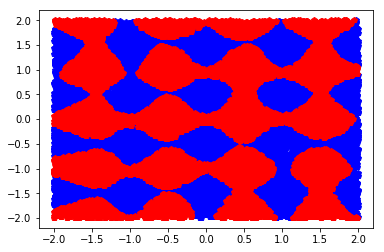

In [30]:
NN = DogikoNeuralNetwork()
NN.SetTrainData(X[:10000], Y[:10000])
NN.SetValidData(X[10000:15000], Y[10000:15000])
NN.SetTestData(X[15000:], Y[15000:])
NN.SetLossFunction("cross entropy")
NN.SetRegularizer(0.001, 2.)
NN.AddHiddenLayer(20, Hypertan())
NN.AddHiddenLayer(20, Hypertan())
NN.SetOutputFunction(Softmax())
NN.SetTerminator(5,10, -0.)

NN.Build()

print(NN.Train(times=500, batch_size=5000, method="Rprop", is_termination=True), end = ", ")
print(NN.GetTrainAccuracy(), NN.GetValidAccuracy(), NN.GetTestAccuracy())

for t in range(30):
    for l in range(NN.GetNumHiddenLayers()):
        NN.UnitsRefined(layer_index=l, method="remove", threshold=2)
        NN.AddUnit(layer_index=l, num_added=2, output_linear_bound=0.001)
    
    NN.ResetCwiseStep(0.01)
    print(NN.Train(times=500, batch_size=5000, method="Rprop", is_termination=True, shuffling=True), end = ", ")    
    print(NN.GetTrainAccuracy(), NN.GetValidAccuracy(), NN.GetTestAccuracy())

I = NN.GetInference(X)[:, 0]
plt.plot(X[:, 0][I>0.5], X[:, 1][I>0.5], "bp")
plt.plot(X[:, 0][I<0.5], X[:, 1][I<0.5], "rp")
plt.show()

### Find suitable units by info ratio of layer output

In [ ]:
NN = DogikoNeuralNetwork()
NN.SetTrainData(X[:10000], Y[:10000])
NN.SetValidData(X[10000:15000], Y[10000:15000])
NN.SetTestData(X[15000:], Y[15000:])
NN.SetLossFunction("cross entropy")
NN.SetRegularizer(0.0001, 1.)
NN.AddHiddenLayer(20, Hypertan())
NN.AddHiddenLayer(20, Hypertan())
NN.SetOutputFunction(Softmax())
NN.SetTerminator(10,30, -0.)

NN.Build()

print(NN.Train(times=1000, batch_size=5000, method="Rprop", is_termination=True), end = ", ")
for l in range(NN.GetNumHiddenLayers()):
    print(NN.hiddenLayerList[l].num_unit, end = ", ")

print(NN.GetTrainAccuracy(), NN.GetValidAccuracy(), NN.GetTestAccuracy())

for t in range(20):
    for l in range(NN.GetNumHiddenLayers()):
        NN.AddUnit(layer_index=l, num_added=1, output_linear_bound=0.01)
    
    NN.ResetCwiseStep(0.001)
    print(NN.Train(times=1000, batch_size=10000, method="Rprop", is_termination=True), end = ", ")
    for l in range(NN.GetNumHiddenLayers()):
        NN.UnitsRefined(layer_index=l, method="info ratio", threshold=0.001)
    
    NN.ResetCwiseStep(0.001)
    print(NN.Train(times=1000, batch_size=10000, method="Rprop", is_termination=True), end = ", ")
    for l in range(NN.GetNumHiddenLayers()):
        print(NN.hiddenLayerList[l].num_unit, end = ", ")
    
    print(NN.GetTrainAccuracy(), NN.GetValidAccuracy(), NN.GetTestAccuracy())

I = NN.GetInference(X)[:, 0]
plt.plot(X[:, 0][I>0.5], X[:, 1][I>0.5], "bp")
plt.plot(X[:, 0][I<0.5], X[:, 1][I<0.5], "rp")
plt.show()

# "Is Skin" on UCI

In [ ]:
X = np.load("../UCI/Is-skin/data-npy/data.npy").astype(np.float64)
Y = np.load("../UCI/Is-skin/data-npy/label.npy").astype(np.float64)
X *= 2/255
X -= 1
shuffle = np.arange(X.shape[0])
np.random.shuffle(shuffle)
X = X[shuffle]
Y = Y[shuffle]

### Train directly

In [ ]:
NN = DogikoNeuralNetwork()
NN.SetTrainData(X[:150000], Y[:150000])
NN.SetValidData(X[150000:200000], Y[150000:200000])
NN.SetTestData(X[200000:], Y[200000:])
NN.SetLossFunction("cross entropy")
NN.SetRegularizer(0.0001, 0.)
NN.AddHiddenLayer(2, Hypertan())
NN.SetOutputFunction(Softmax())
NN.SetTerminator(10,30, -0.01)
for t in range(10):
    NN.Build()
    print(NN.Train(times=2000, batch_size=50000, method="Rprop", is_termination=True), end = ", ")
    print(NN.GetTrainAccuracy(), NN.GetValidAccuracy(), NN.GetTestAccuracy())

### Repeat add-fit-kill-fit for fix number of units

In [ ]:
NN = DogikoNeuralNetwork()
NN.SetTrainData(X[:150000], Y[:150000])
NN.SetValidData(X[150000:200000], Y[150000:200000])
NN.SetTestData(X[200000:], Y[200000:])
NN.SetLossFunction("cross entropy")
NN.SetRegularizer(0.0001, 1.)
NN.AddHiddenLayer(2, Hypertan())
NN.SetOutputFunction(Softmax())
NN.SetTerminator(10,30, -0.)

NN.Build()

print(NN.Train(times=2000, batch_size=50000, method="Rprop", is_termination=True), end = ", ")
for l in range(NN.GetNumHiddenLayers()):
    print(NN.hiddenLayerList[l].num_unit, end = ", ")

print(NN.GetTrainAccuracy(), NN.GetValidAccuracy(), NN.GetTestAccuracy())

for t in range(10):
    for l in range(NN.GetNumHiddenLayers()):
        NN.AddUnit(layer_index=l, num_added=1, output_linear_bound=0.01)
    
    NN.ResetCwiseStep(0.001)
    print(NN.Train(times=2000, batch_size=50000, method="Rprop", is_termination=True), end = ", ")
    for l in range(NN.GetNumHiddenLayers()):
        NN.UnitsRefined(layer_index=l, method="remain", threshold=2, enhance_alert=False)
    
    NN.ResetCwiseStep(0.001)
    print(NN.Train(times=2000, batch_size=50000, method="Rprop", is_termination=True), end = ", ")
    for l in range(NN.GetNumHiddenLayers()):
        print(NN.hiddenLayerList[l].num_unit, end = ", ")
    
    print(NN.GetTrainAccuracy(), NN.GetValidAccuracy(), NN.GetTestAccuracy())

### Find suitable units by info ratio of layer output

In [ ]:
NN = DogikoNeuralNetwork()
NN.SetTrainData(X[:150000], Y[:150000])
NN.SetValidData(X[150000:200000], Y[150000:200000])
NN.SetTestData(X[200000:], Y[200000:])
NN.SetLossFunction("cross entropy")
NN.SetRegularizer(0.0001, 0.)
NN.AddHiddenLayer(10, Hypertan())
NN.SetOutputFunction(Softmax())
NN.SetTerminator(10,30, -0.01)

NN.Build()

print(NN.Train(times=2000, batch_size=50000, method="Rprop", is_termination=True), end = ", ")
for l in range(NN.GetNumHiddenLayers()):
    print(NN.hiddenLayerList[l].num_unit, end = ", ")

print(NN.GetTrainAccuracy(), NN.GetValidAccuracy(), NN.GetTestAccuracy())

for t in range(20):
    for l in range(NN.GetNumHiddenLayers()):
        NN.AddUnit(layer_index=l, num_added=1, output_linear_bound=0.01)
    
    NN.ResetCwiseStep(0.001)
    print(NN.Train(times=2000, batch_size=50000, method="Rprop", is_termination=True), end = ", ")
    for l in range(NN.GetNumHiddenLayers()):
        NN.UnitsRefined(layer_index=l, method="info ratio", threshold=0.0001)
    
    NN.ResetCwiseStep(0.001)
    print(NN.Train(times=2000, batch_size=50000, method="Rprop", is_termination=True), end = ", ")
    for l in range(NN.GetNumHiddenLayers()):
        print(NN.hiddenLayerList[l].num_unit, end = ", ")
    
    print(NN.GetTrainAccuracy(), NN.GetValidAccuracy(), NN.GetTestAccuracy())